In [454]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [455]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torchtext.legacy import data
import random
import torch.nn as nn
import torch.optim as optim
from os.path import exists
from nltk.stem.porter import PorterStemmer
import torchvision
import torchvision.transforms as transforms
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [456]:
dataset = pd.read_csv('/content/drive/Shareddrives/Patter assignment/Assignment 3/Dataset/Dataset 3.csv',encoding='latin1')

In [457]:
print(dataset.head())

                                              tweets  sentiment
0  just had a real good moment. i missssssssss hi...          0
1         is reading manga  http://plurk.com/p/mzp1e          0
2  @comeagainjen http://twitpic.com/2y2lx - http:...          0
3  @lapcat Need to send 'em to my accountant tomo...          0
4      ADD ME ON MYSPACE!!!  myspace.com/LookThunder          0


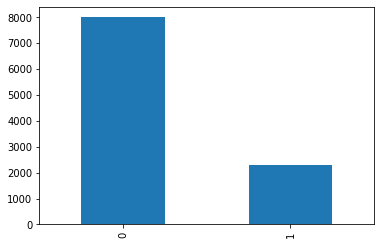

In [458]:
dataset['sentiment'].value_counts().sort_index().plot.bar()

In [459]:
dataset['tweets'] = dataset['tweets'].str.lower()
dataset['tweets'].apply(lambda x: x.lower()) #transform text to lowercase
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub('<.*?>', '' , x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub('\[.*?\]', '' , x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub('<.*?>+', '' , x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub(r"http\S+", " " , x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub(r"(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*", " " , x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub(r"http\S+", " " , x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub('\n', '', x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub('\w*\d\w*', '', x))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x,flags=re.MULTILINE))
dataset['tweets'] = dataset['tweets'].apply(lambda x: re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", '', x,flags=re.MULTILINE))
dataset['tweets'].head()

0    just had a real good moment i missssssssss him...
1                                  is reading manga   
2                                   comeagainjen      
3    lapcat need to send em to my accountant tomorr...
4             add me on myspace  myspacecomlookthunder
Name: tweets, dtype: object

In [460]:
n = len(dataset) 
TEST_SIZE = 0.2
n_test = int(TEST_SIZE * n) 
trainDataset, testDataSet = train_test_split(dataset, test_size=0.2, random_state=42) #random split dataset


In [461]:
print(f'Number of training examples: {len(trainDataset)}')
print(f'Number of testing examples: {len(testDataSet)}')

Number of training examples: 8251
Number of testing examples: 2063


In [462]:
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [463]:

class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(dataset.tweets.tolist())
        self.labels = dataset.sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [464]:
device = torch.device('cpu')
device

device(type='cpu')

In [465]:
sequence_length = 28
hidden_size = 256
num_layers = 4
num_classes = 1
batch_sizeRNN = 100
num_epochs = 2
learning_rate = 0.02

In [466]:
trainDataset = Sequences(trainDataset)
trainLoader = DataLoader(trainDataset, batch_size=900)
print(len(trainLoader))


12


In [467]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])
        return out

In [468]:
model = RNN(len(trainDataset.token2idx), hidden_size, num_layers,num_classes)
model.to(device)

RNN(
  (rnn): RNN(20467, 256, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [469]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [470]:
train_losses = []
train_acc = []
total_step = 8251
for epoch in range(70):
    losses = []
    total = 0
    for inputs, target in trainLoader:
        
        inputs=inputs.float()
        inputs=inputs.to(device)
        targets=target.float()
        target=targets.to(device)
        model.zero_grad()      
        output = model(inputs)
        loss = criterion(output.squeeze(), target) 
        rounded_preds = torch.round(torch.sigmoid(output.squeeze()))
        correct = (rounded_preds == target).float() #convert into float for division 
        acc = correct.sum() / len(correct)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        total += 1
        
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
    train_acc.append(acc)
        
    print(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.10f}\tTrain Accurecy: {acc*100:.10f}')  
    

Epoch #1	Train Loss: 0.7047823510	Train Accurecy: 100.0000000000
Epoch #2	Train Loss: 6.5885947967	Train Accurecy: 95.8937225342
Epoch #3	Train Loss: 6.3440540653	Train Accurecy: 0.2415458858
Epoch #4	Train Loss: 0.3138124348	Train Accurecy: 99.7584533691
Epoch #5	Train Loss: 4.8086911834	Train Accurecy: 0.2415458858
Epoch #6	Train Loss: 1.3600446813	Train Accurecy: 10.8695650101
Epoch #7	Train Loss: 3.6503253630	Train Accurecy: 2.4154589176
Epoch #8	Train Loss: 1.4859072248	Train Accurecy: 25.3623180389
Epoch #9	Train Loss: 1.8141660209	Train Accurecy: 39.1304359436
Epoch #10	Train Loss: 0.8555981986	Train Accurecy: 94.9275360107
Epoch #11	Train Loss: 0.3864816083	Train Accurecy: 98.5507278442
Epoch #12	Train Loss: 0.4645404226	Train Accurecy: 94.2028961182
Epoch #13	Train Loss: 0.2005963271	Train Accurecy: 89.8550720215
Epoch #14	Train Loss: 0.1866694960	Train Accurecy: 96.8599014282
Epoch #15	Train Loss: 0.1357003554	Train Accurecy: 96.1352615356
Epoch #16	Train Loss: 0.1259453078	T

In [471]:
testDataset = Sequences(testDataSet)
testLoader = DataLoader(testDataset, batch_size=900)
test_losses=[]
test_acc=[]
sentiment_texts = []
predictions = []
prediction_probs = []
groundTruth_values = []
for epoch in range(70): 
  epoch_loss = 0
  epoch_acc = 0
  model.eval()    
  with torch.no_grad():
      for inputs, target in testLoader:
          texts = testDataSet["tweets"]
          inputs=inputs.float()
          inputs=inputs.to(device)
          targets=target.float()
          target=targets.to(device)
          outputPred = model(inputs)
          _, preds = torch.max(outputPred, dim=1)  
          tloss = criterion(outputPred.squeeze(), target)
          rounded_preds = torch.round(torch.sigmoid(outputPred.squeeze()))
          correct = (rounded_preds == target).float() #convert into float for division 
          tacc = correct.sum() / len(correct)
          sentiment_texts.extend(texts)
          predictions.extend(preds)
          prediction_probs.extend(outputPred)
          groundTruth_values.extend(targets)
          epoch_loss += tloss.item()
          epoch_acc += tacc.item()
 
  epoch_loss=epoch_loss/len(testLoader)
  epoch_acc=epoch_acc/len(testLoader)
  test_losses.append(epoch_loss)
  test_acc.append(epoch_acc)
        
  print(f'Epoch #{epoch + 1}\tTest Loss: {epoch_loss:.10f}\tTest Accurecy: {epoch_acc*100:.10f}')

Epoch #1	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #2	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #3	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #4	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #5	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #6	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #7	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #8	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #9	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #10	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #11	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #12	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #13	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #14	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #15	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
Epoch #16	Test Loss: 0.0229551542	Test Accurecy: 99.4102249543
E

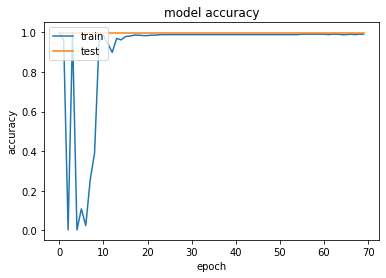

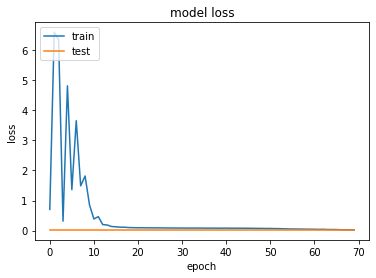

In [472]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

confusion_matrix

[[560000      0]
 [161980      0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.78      1.00      0.87    560000
         1.0       0.00      0.00      0.00    161980

    accuracy                           0.78    721980
   macro avg       0.39      0.50      0.44    721980
weighted avg       0.60      0.78      0.68    721980



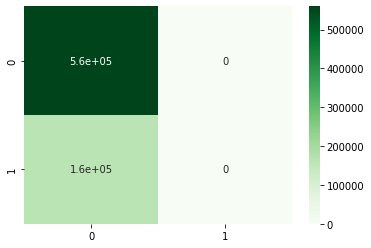

In [480]:
from sklearn.metrics import classification_report
conf=confusion_matrix(groundTruth_values,predictions)
sn.heatmap(conf, cmap="Greens", annot=True)# font size
print("confusion_matrix\n")
print(conf)
evaluation=classification_report(groundTruth_values,predictions)
print(evaluation)

In [482]:
from sklearn.metrics import f1_score
f1_score(groundTruth_values, predictions, average='micro')

0.7756447547023463

In [483]:
from sklearn.metrics import precision_score
precision_score(groundTruth_values, predictions, average='micro')

0.7756447547023463